<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/Causal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY HEAD AND NECK CANCER RESPONSE**

In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from scipy import stats

from lifelines import KaplanMeierFitter


In [ ]:
#load data - preprocessed analytic data - set
rad_analysis = pd.read_csv("/content/rad_data_analysis (6).csv")
print(rad_analysis.shape)
rad_analysis.head()


(3271, 41)


,patient_id,treatment,time_os_days,event_os,time_pfs_days,event_pfs,time_pfs_days.1,event_pfs.1,age,sex,...,is_non_tnm,tnm_structural_missing,followup_days,dose,fx,length_fu,d_per_fx,BED,EQD2,BED_eff
0,RADCURE-0005,0,446.0,1,446.0,1,446.0,1,62.6,Female,...,0,0,446.0,60.0,25,1.317808,2.40,74.400,62.000000,74.400
1,RADCURE-0006,0,527.0,1,527.0,1,527.0,1,87.3,Male,...,0,0,527.0,51.0,20,1.520548,2.55,64.005,53.337500,64.005
2,RADCURE-0007,0,756.0,0,756.0,0,756.0,0,49.9,Male,...,0,0,756.0,64.0,40,2.126027,1.60,74.240,61.866667,74.240
3,RADCURE-0009,0,2059.0,0,2059.0,0,2059.0,0,72.3,Male,...,0,0,2059.0,70.0,35,5.791781,2.00,84.000,70.000000,84.000
4,RADCURE-0010,0,3444.0,0,3444.0,0,3444.0,0,59.7,Female,...,0,0,3444.0,64.0,40,9.512329,1.60,74.240,61.866667,74.240


In [ ]:
rad_analysis.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days', 'dose', 'fx', 'length_fu',
       'd_per_fx', 'BED', 'EQD2', 'BED_eff'],
      dtype='object')

**Missingness**




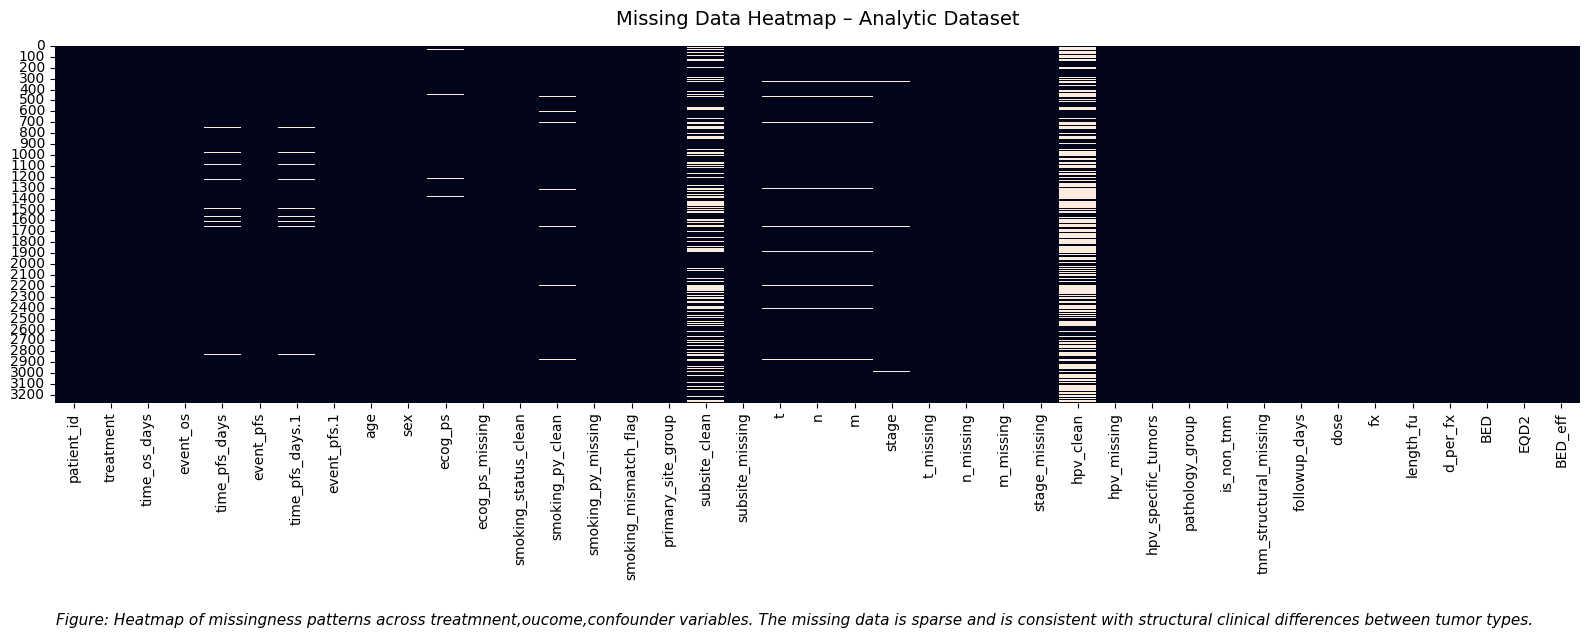

In [ ]:
#missing data heatmap
plt.figure(figsize = (16,6))
sns.heatmap(rad_analysis.isna(), cbar= False)
plt.title("Missing Data Heatmap – Analytic Dataset", fontsize=14, pad=15)

plt.figtext(
    0.5, -0.05,
    "Figure: Heatmap of missingness patterns across treatmnent,oucome,confounder variables. "
    "The missing data is sparse and is consistent with structural clinical differences between tumor types.",
    wrap=True, ha='center', fontsize=11, style='italic'
)

plt.tight_layout()
plt.savefig('missing_data_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()


The missingness heatmap show that the key survival and treatment variables are complete and are reliable for making causal inferences. ECOG performance status is missing a single value, and the 'T', 'N', 'M', 'Stage' have small missingness. The missingnes in the  'subsite' and 'HPV' results predominantly reflect clinical irrelevance outside specific tumor groups that is the non- oropharyngeal cancers. The missingness is structural rather than random. Smoking pack-years has limited and clinically plausible statistical missingness, appropriately which we handled earlier with missingness indicators.

In [ ]:
rad_analysis.isna().sum()

,0
patient_id,0
treatment,0
time_os_days,0
event_os,0
time_pfs_days,77
event_pfs,0
time_pfs_days.1,77
event_pfs.1,0
age,0
sex,0


# Treatment Vs Covariates

**Age**

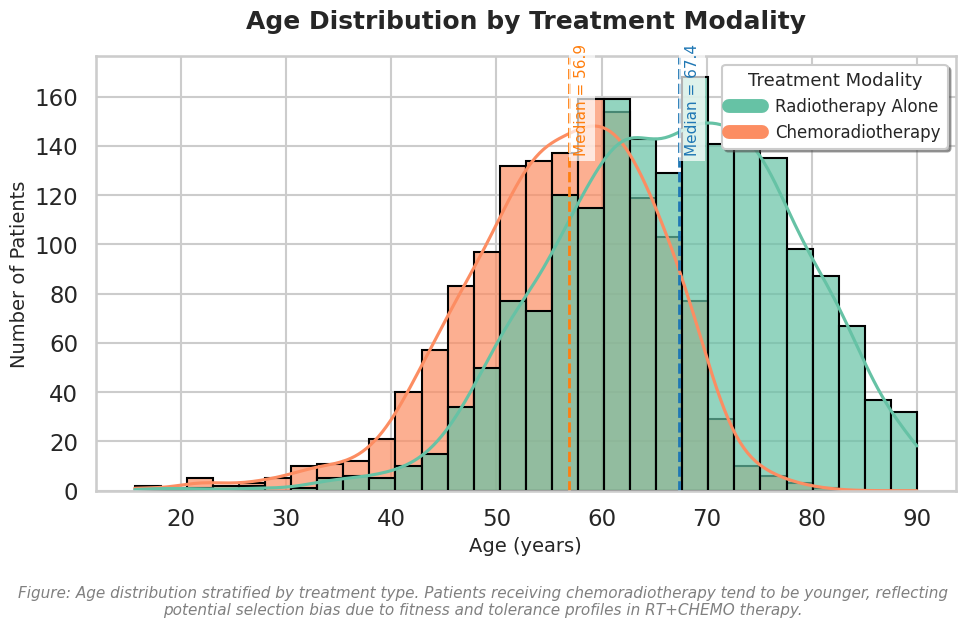

In [ ]:

rad_analysis['treatment_label'] = rad_analysis['treatment'].map({
    0: 'Radiotherapy Alone',
    1: 'Chemoradiotherapy'
})
rad_analysis['treatment_label'] = pd.Categorical(
    rad_analysis['treatment_label'],
    categories=['Radiotherapy Alone', 'Chemoradiotherapy'],
    ordered=True
)


sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=rad_analysis,x='age',hue='treatment_label',
    hue_order=['Radiotherapy Alone', 'Chemoradiotherapy'],  # enforce order and label use
    bins=30,kde=True,palette='Set2',edgecolor='black', alpha=0.7)
for treatment, color in zip(['Radiotherapy Alone', 'Chemoradiotherapy'], ['#1f77b4', '#ff7f0e']):
    median_val = rad_analysis.loc[
        rad_analysis['treatment_label'] == treatment, 'age'
    ].median()
    plt.axvline(median_val, color=color, linestyle='--', linewidth=2)
    plt.text(
        median_val + 0.5, plt.ylim()[1] * 0.9,
        f"Median = {median_val:.1f}",
        color=color,
        fontsize=11,
        rotation=90,
        va='center',
        ha='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

plt.title("Age Distribution by Treatment Modality", fontsize=18, weight='bold', pad=20)
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)
handles, labels = ax.get_legend_handles_labels()
if not labels or 'treatment_label' in labels[0].lower():
    handles = [plt.Line2D([0], [0], color= '#66C2A5', lw=10, label='Radiotherapy Alone'),
               plt.Line2D([0], [0],color= '#FC8D62', lw=10, label='Chemoradiotherapy')]
    plt.legend(handles=handles, title="Treatment Modality", fontsize=12, title_fontsize=13,
               loc='upper right', frameon=True, shadow=True, fancybox=True)
else:
    plt.legend(title="Treatment Modality", fontsize=12, title_fontsize=13,
               loc='upper right', frameon=True, shadow=True, fancybox=True)
plt.figtext(
    0.5, -0.05,
    "Figure: Age distribution stratified by treatment type. "
    "Patients receiving chemoradiotherapy tend to be younger, reflecting potential selection bias "
    "due to fitness and tolerance profiles in RT+CHEMO therapy.",
    wrap=True, ha='center', fontsize=11, style='italic', color='gray'
)

plt.tight_layout()
plt.savefig('Age_distribution_by_treatment_labeled.png', dpi=300, bbox_inches='tight')
plt.show()

# HPV Status

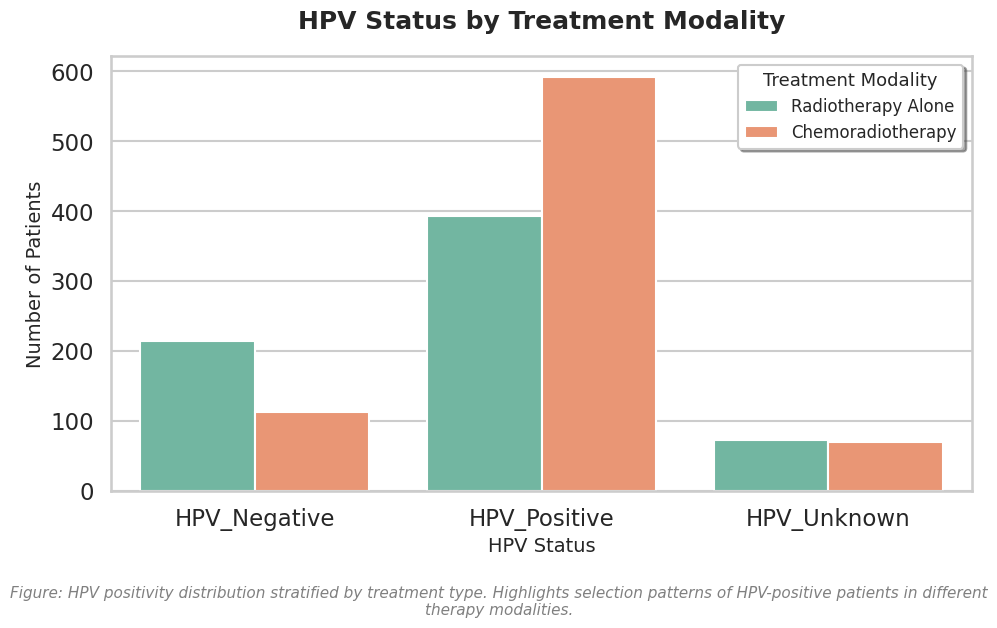

In [ ]:
rad_analysis['treatment_label'] = rad_analysis['treatment'].map({
    0: 'Radiotherapy Alone',
    1: 'Chemoradiotherapy'
})
rad_analysis['treatment_label'] = pd.Categorical(
    rad_analysis['treatment_label'],
    categories=['Radiotherapy Alone', 'Chemoradiotherapy'],
    ordered=True
)

# Set theme
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(10,6))

# Plot countplot for HPV
ax = sns.countplot( data=rad_analysis,x='hpv_clean',hue='treatment_label',
    hue_order=['Radiotherapy Alone', 'Chemoradiotherapy'],palette=['#66C2A5','#FC8D62'])
plt.title("HPV Status by Treatment Modality", fontsize=18, weight='bold', pad=20)
plt.xlabel("HPV Status", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,labels=labels,title="Treatment Modality",fontsize=12,title_fontsize=13,
    loc='upper right',frameon=True, shadow=True, fancybox=True)
plt.figtext(
    0.5, -0.05,
    "Figure: HPV positivity distribution stratified by treatment type. "
    "Highlights selection patterns of HPV-positive patients in different therapy modalities.",
    wrap=True, ha='center', fontsize=11, style='italic', color='gray'
)

plt.tight_layout()
plt.savefig('HPV_status_by_treatment.png', dpi=300, bbox_inches='tight')
plt.show()

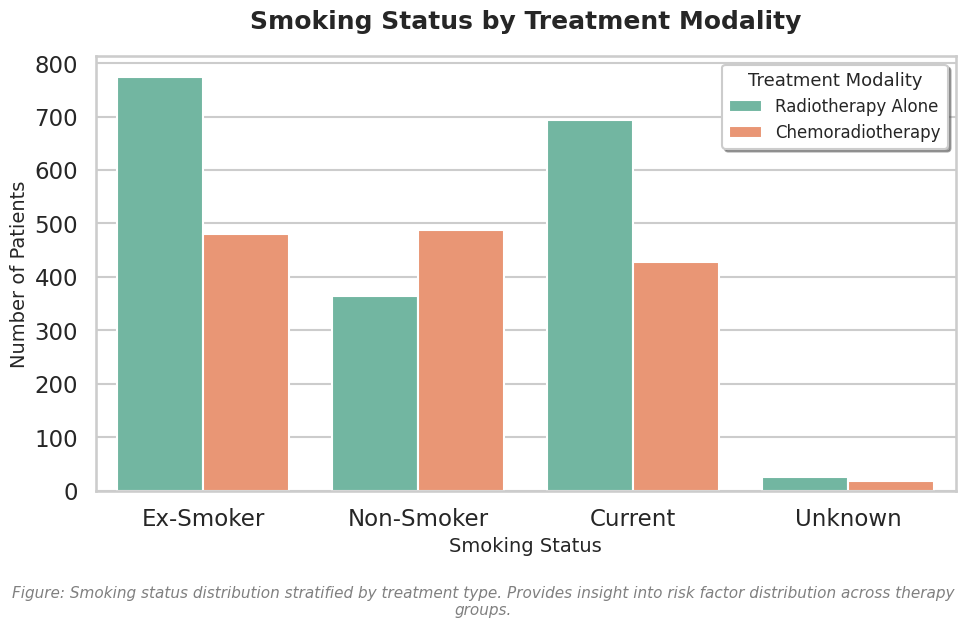

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(
    data=rad_analysis,
    x='smoking_status_clean',
    hue='treatment_label',
    hue_order=['Radiotherapy Alone', 'Chemoradiotherapy'],
    palette=['#66C2A5','#FC8D62']
)

plt.title("Smoking Status by Treatment Modality", fontsize=18, weight='bold', pad=20)
plt.xlabel("Smoking Status", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)

handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Treatment Modality",
    fontsize=12,
    title_fontsize=13,
    loc='upper right',
    frameon=True, shadow=True, fancybox=True
)

plt.figtext(
    0.5, -0.05,
    "Figure: Smoking status distribution stratified by treatment type. "
    "Provides insight into risk factor distribution across therapy groups.",
    wrap=True, ha='center', fontsize=11, style='italic', color='gray'
)

plt.tight_layout()
plt.savefig('Smoking_status_by_treatment.png', dpi=300, bbox_inches='tight')
plt.show()

# T,N,M Staging

**T**

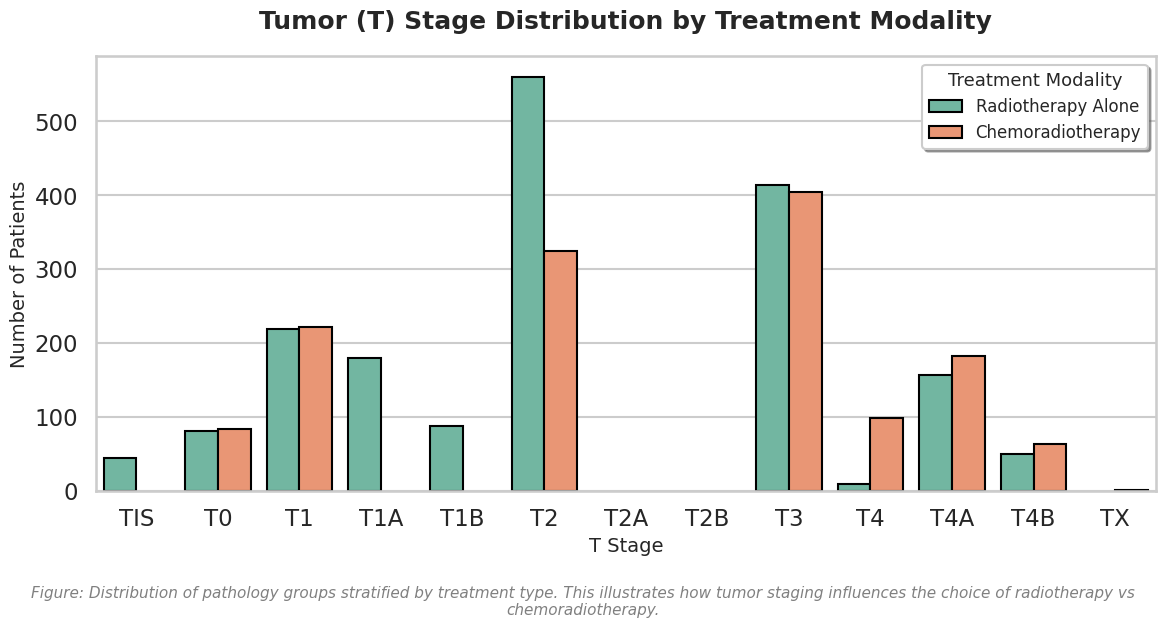

In [ ]:
rad_analysis['t'] = rad_analysis['t'].astype(str).str.strip().str.upper()
rad_analysis['t'] = pd.Categorical(
    rad_analysis['t'],
    categories=['TIS','T0','T1','T1A','T1B','T2','T2A','T2B','T3','T4','T4A','T4B','TX'],
    ordered=True
)

# Map treatment labels
rad_analysis['treatment_label'] = rad_analysis['treatment'].map({
    0: 'Radiotherapy Alone',
    1: 'Chemoradiotherapy'
})
rad_analysis['treatment_label'] = pd.Categorical(
    rad_analysis['treatment_label'],
    categories=['Radiotherapy Alone','Chemoradiotherapy'],
    ordered=True
)

# Plot
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))

ax = sns.countplot(
    data=rad_analysis,
    x='t',
    hue='treatment_label',
    palette=['#66C2A5','#FC8D62'],
    edgecolor='black'
)

plt.title("Tumor (T) Stage Distribution by Treatment Modality", fontsize=18, weight='bold', pad=20)
plt.xlabel("T Stage", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Treatment Modality",
    fontsize=12,
    title_fontsize=13,
    loc='upper right',
    frameon=True, shadow=True, fancybox=True
)
plt.figtext(
    0.5, -0.05,
    "Figure: Distribution of pathology groups stratified by treatment type. "
    "This illustrates how tumor staging influences the choice of radiotherapy vs chemoradiotherapy.",
    wrap=True, ha='center', fontsize=11, style='italic', color='gray'
)

plt.tight_layout()
plt.savefig('Pathology_by_treatment.png', dpi=300, bbox_inches='tight')
plt.show()

**N**

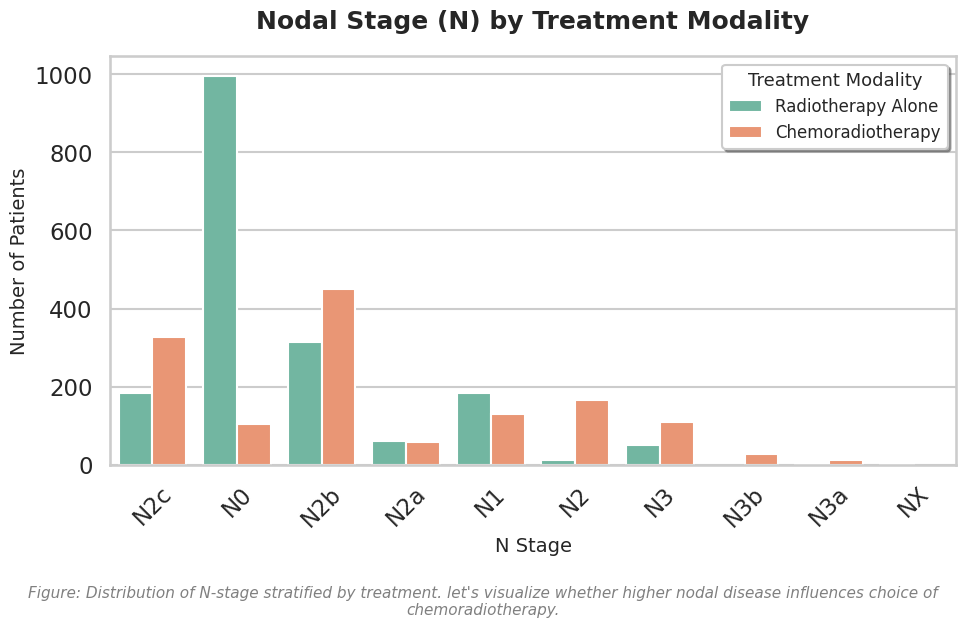

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(
    data=rad_analysis,
    x='n',
    hue='treatment_label',
    hue_order=['Radiotherapy Alone', 'Chemoradiotherapy'],
    palette=['#66C2A5','#FC8D62']
)

plt.title("Nodal Stage (N) by Treatment Modality", fontsize=18, weight='bold', pad=20)
plt.xlabel("N Stage", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)
plt.xticks(rotation=45)

handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Treatment Modality",
    fontsize=12,
    title_fontsize=13,
    loc='upper right',
    frameon=True, shadow=True, fancybox=True
)

plt.figtext(
    0.5, -0.05,
    "Figure: Distribution of N-stage stratified by treatment. "
    "let's visualize whether higher nodal disease influences choice of chemoradiotherapy.",
    wrap=True, ha='center', fontsize=11, style='italic', color='gray'
)

plt.tight_layout()
plt.savefig('N_stage_by_treatment.png', dpi=300, bbox_inches='tight')
plt.show()


**M**

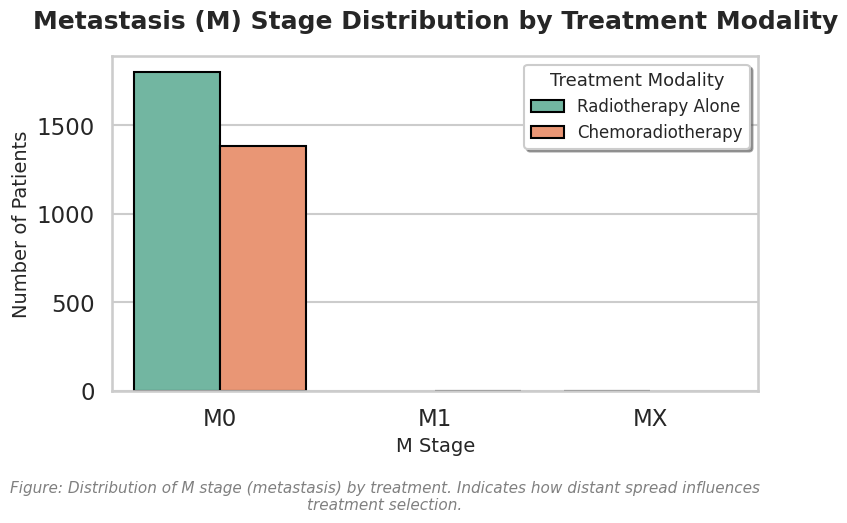

In [ ]:
# Ensure M stage is categorical
rad_analysis['m'] = rad_analysis['m'].astype(str).str.strip().str.upper()
rad_analysis['m'] = pd.Categorical(
    rad_analysis['m'],
    categories=['M0','M1','MX'],
    ordered=True
)
plt.figure(figsize=(8,5))
ax = sns.countplot(
    data=rad_analysis,
    x='m',
    hue='treatment_label',
    palette=['#66C2A5','#FC8D62'],
    edgecolor='black'
)

plt.title("Metastasis (M) Stage Distribution by Treatment Modality", fontsize=18, weight='bold', pad=20)
plt.xlabel("M Stage", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)

handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Treatment Modality",
    fontsize=12,
    title_fontsize=13,
    loc='upper right',
    frameon=True, shadow=True, fancybox=True
)

plt.figtext(
    0.5, -0.05,
    "Figure: Distribution of M stage (metastasis) by treatment. "
    "Indicates how distant spread influences treatment selection.",
    wrap=True, ha='center', fontsize=11, style='italic', color='gray'
)

plt.tight_layout()
plt.savefig('M_stage_by_treatment.png', dpi=300, bbox_inches='tight')
plt.show()


#Primary Site

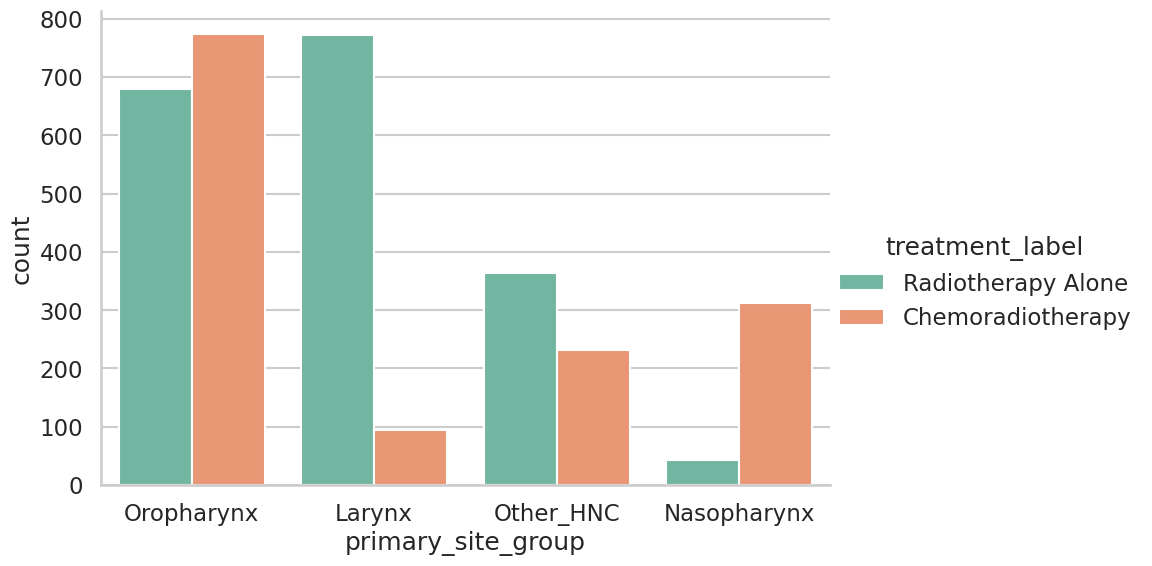

In [ ]:
sns.catplot(
    data=rad_analysis,
    x='primary_site_group',
    hue='treatment_label',
    kind='count',
    palette=['#66C2A5','#FC8D62'],
    height=6, aspect=1.5
)

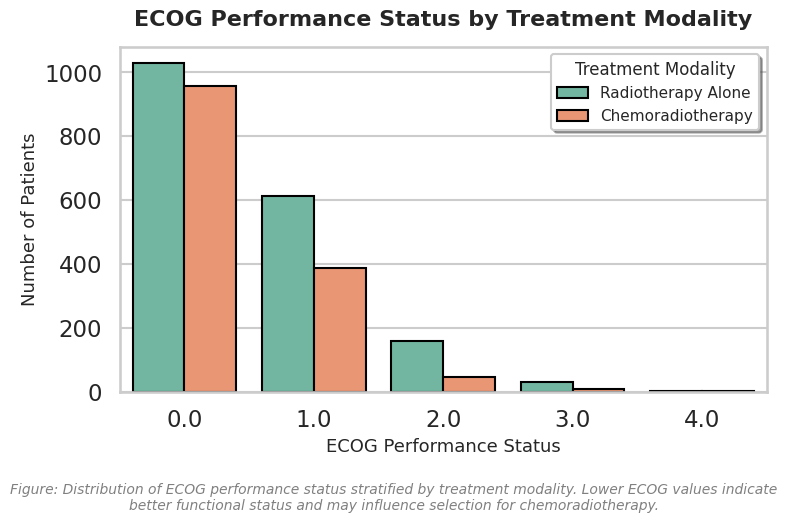

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map treatment labels for clarity
rad_analysis['treatment_label'] = rad_analysis['treatment'].map({
    0: 'Radiotherapy Alone',
    1: 'Chemoradiotherapy'
})
rad_analysis['treatment_label'] = pd.Categorical(
    rad_analysis['treatment_label'],
    categories=['Radiotherapy Alone', 'Chemoradiotherapy'],
    ordered=True
)

# Ensure ECOG is categorical
rad_analysis['ecog_ps'] = rad_analysis['ecog_ps'].astype('category')

# Set theme
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(8,5))

# Count plot: ECOG by treatment
ax = sns.countplot(
    data=rad_analysis,
    x='ecog_ps',
    hue='treatment_label',
    palette=['#66C2A5','#FC8D62'],  # Set2-like colors
    edgecolor='black'
)

# Titles and labels
plt.title("ECOG Performance Status by Treatment Modality", fontsize=16, weight='bold', pad=15)
plt.xlabel("ECOG Performance Status", fontsize=13)
plt.ylabel("Number of Patients", fontsize=13)

# Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Treatment Modality",
    fontsize=11,
    title_fontsize=12,
    loc='upper right',
    frameon=True, shadow=True, fancybox=True
)

# Optional caption
plt.figtext(
    0.5, -0.05,
    "Figure: Distribution of ECOG performance status stratified by treatment modality. "
    "Lower ECOG values indicate better functional status and may influence selection for chemoradiotherapy.",
    wrap=True, ha='center', fontsize=10, style='italic', color='gray'
)

plt.tight_layout()
plt.savefig('ECOG_by_treatment.png', dpi=300, bbox_inches='tight')
plt.show()


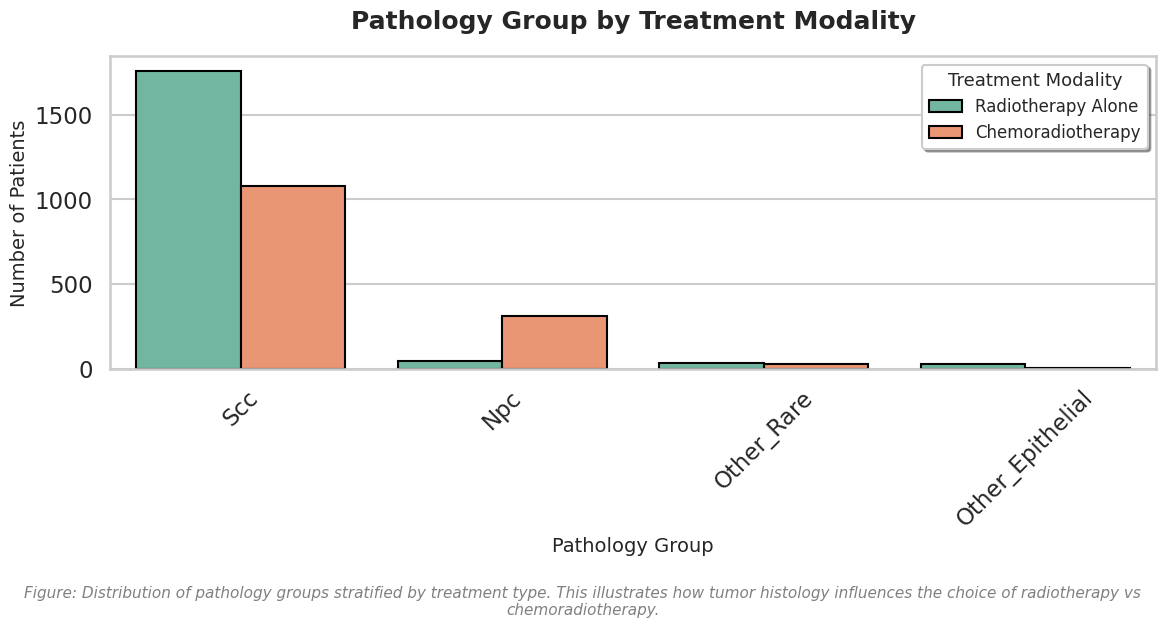

In [ ]:
rad_analysis['treatment_label'] = rad_analysis['treatment'].map({
    0: 'Radiotherapy Alone',
    1: 'Chemoradiotherapy'
})
rad_analysis['treatment_label'] = pd.Categorical(
    rad_analysis['treatment_label'],
    categories=['Radiotherapy Alone','Chemoradiotherapy'],
    ordered=True
)
rad_analysis['pathology_group'] = rad_analysis['pathology_group'].astype(str).str.strip().str.title()
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))

ax = sns.countplot(
    data=rad_analysis,
    x='pathology_group',
    hue='treatment_label',
    palette=['#66C2A5','#FC8D62'],
    edgecolor='black'
)

plt.title("Pathology Group by Treatment Modality", fontsize=18, weight='bold', pad=20)
plt.xlabel("Pathology Group", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)
plt.xticks(rotation=45)
# Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Treatment Modality",
    fontsize=12,
    title_fontsize=13,
    loc='upper right',
    frameon=True, shadow=True, fancybox=True
)
plt.figtext(
    0.5, -0.05,
    "Figure: Distribution of pathology groups stratified by treatment type. "
    "This illustrates how tumor histology influences the choice of radiotherapy vs chemoradiotherapy.",
    wrap=True, ha='center', fontsize=11, style='italic', color='gray'
)
plt.tight_layout()
plt.savefig('Pathology_by_treatment.png', dpi=300, bbox_inches='tight')
plt.show()


# **Survival Outcome vs covariates**

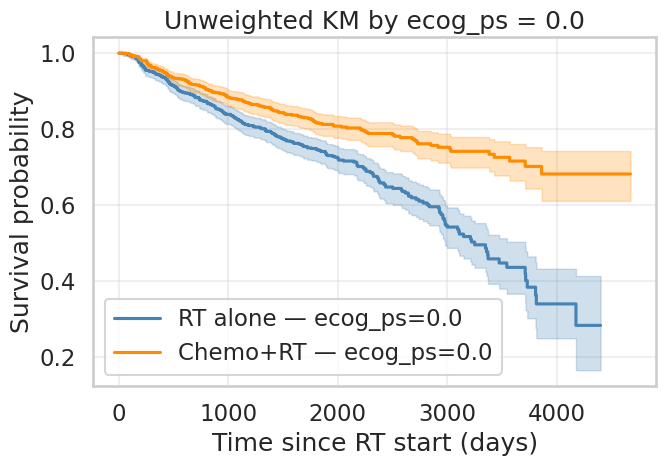

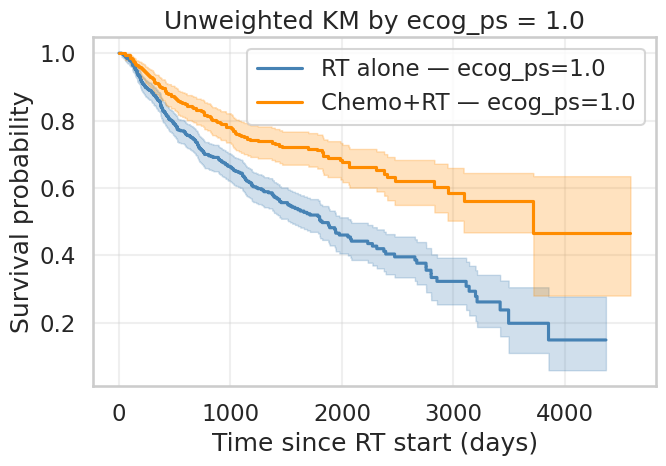

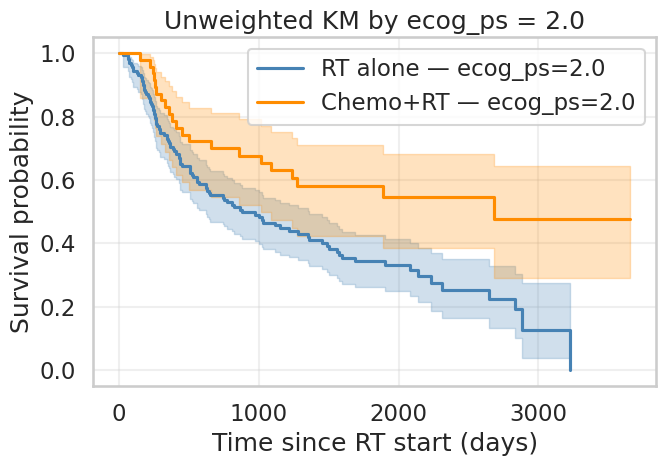

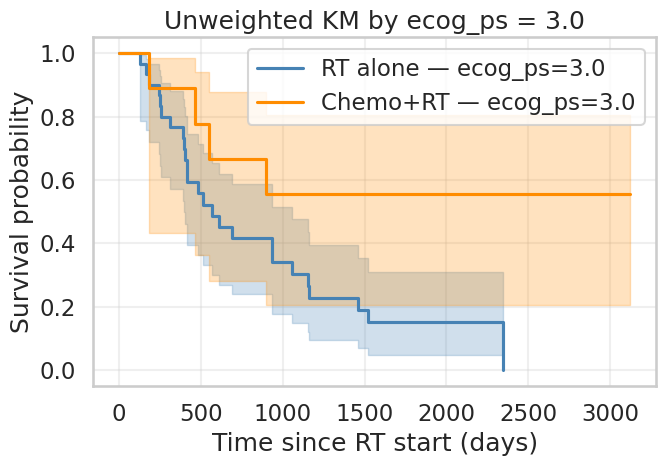

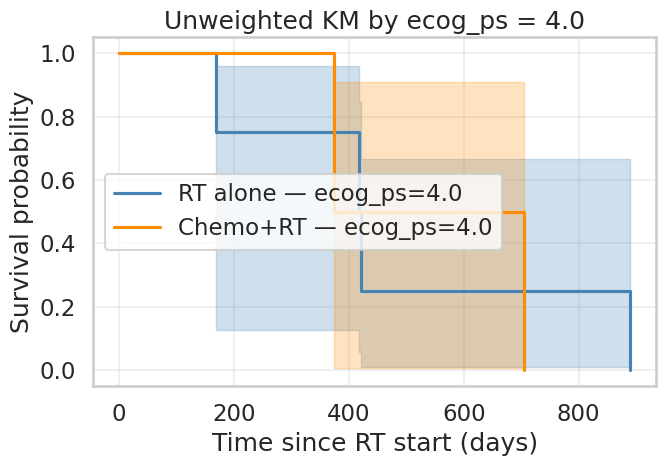

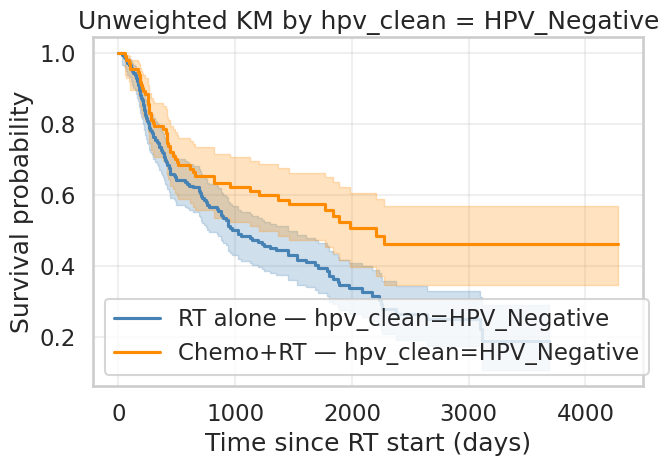

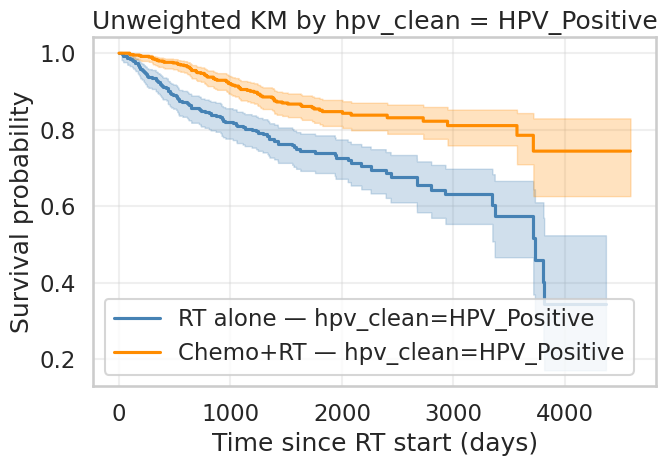

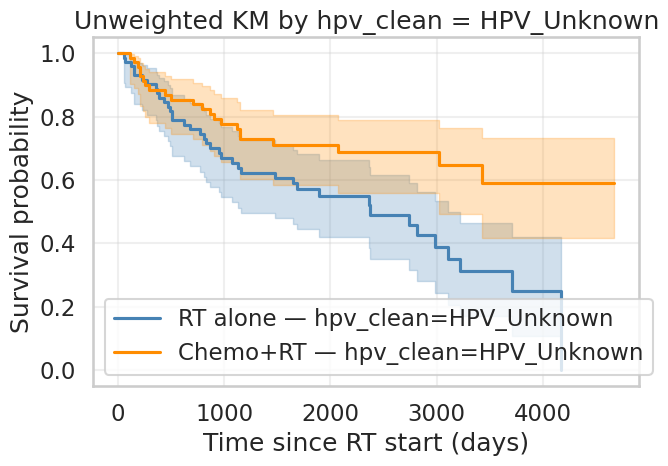

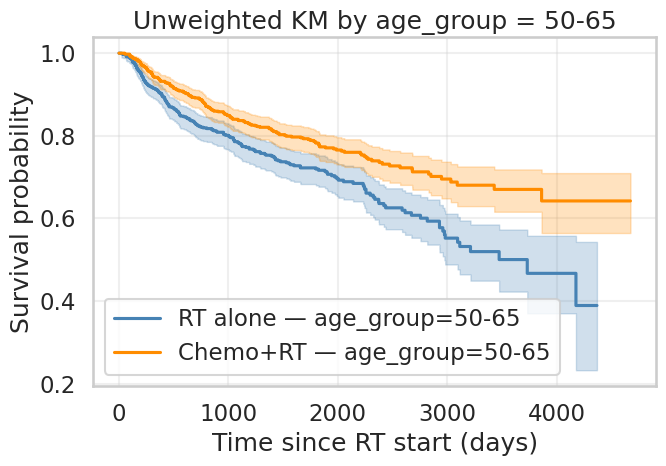

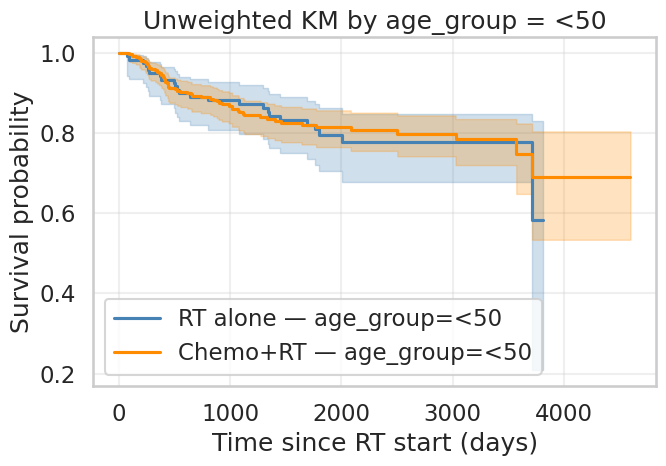

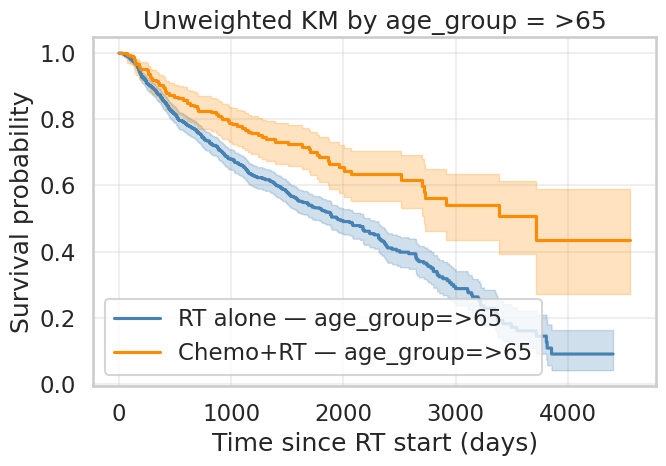

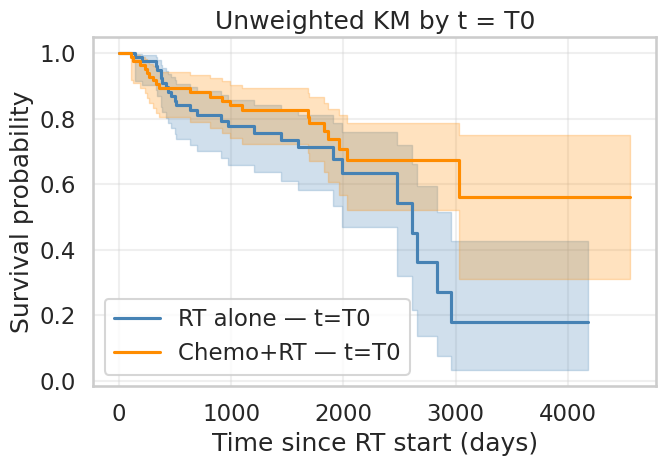

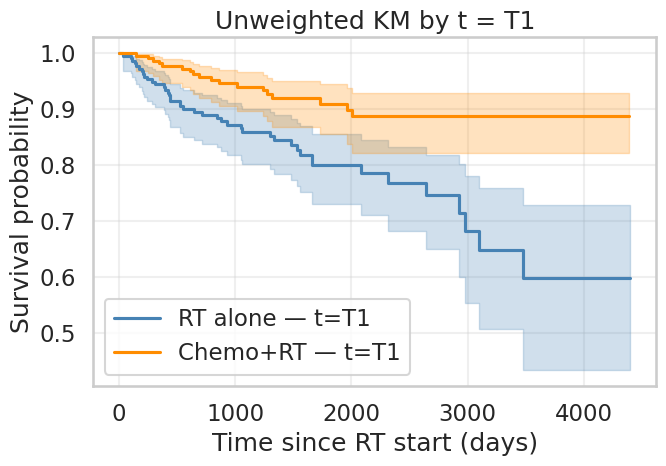

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

<Figure size 700x500 with 0 Axes>

In [ ]:
# Working copy (unweighted)
df_unw = rad_analysis.copy()

# Create simple age groups (adjust bins if you prefer)
if 'age' in df_unw.columns:
    bins = [0, 50, 65, 120]                # <50, 50-65, >65
    labels = ['<50', '50-65', '>65']
    df_unw['age_group'] = pd.cut(df_unw['age'], bins=bins, labels=labels, right=False)

# Basic KM plotting function for unweighted data
def plot_unweighted_km_by_group(df, group_col, title_prefix="Unweighted KM by"):
    """Plot unweighted Kaplan–Meier curves stratified by treatment within each level of group_col."""
    if group_col not in df.columns:
        print(f"Column {group_col} not found — skipping.")
        return

    levels = df[group_col].dropna().unique()
    levels = sorted(levels, key=lambda x: (str(x)))  # stable order

    for lvl in levels:
        subset = df[df[group_col] == lvl]
        if subset.empty:
            continue

        T = subset['time_os_days']
        E = subset['event_os']
        A = subset['treatment']

        km0 = KaplanMeierFitter(label=f"RT alone — {group_col}={lvl}")
        km1 = KaplanMeierFitter(label=f"Chemo+RT — {group_col}={lvl}")

        plt.figure(figsize=(7,5))
        km0.fit(T[A==0], event_observed=E[A==0])
        km1.fit(T[A==1], event_observed=E[A==1])

        ax = km0.plot(ci_show=True, color='steelblue')
        km1.plot(ci_show=True, color='darkorange', ax=ax)

        plt.title(f"{title_prefix} {group_col} = {lvl}")
        plt.xlabel("Time since RT start (days)")
        plt.ylabel("Survival probability")
        plt.grid(alpha=0.3)
        plt.tight_layout()

        plt.show()


# Columns to plot (unweighted)
subgroup_columns = [
    'ecog_ps', 'hpv_clean', 'age_group',
    't', 'n', 'm', 'pathology_group'
]

for col in subgroup_columns:
    if col in df_unw.columns:
        plot_unweighted_km_by_group(df_unw, col, title_prefix="Unweighted KM by")